Necessary Library Imports

In [2]:
import random
import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers

Mount the Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Read the data file

In [4]:
import csv
import random

csv_file = "/content/drive/MyDrive/Deep_Learning/MiniProject03/data.csv"

# Read the CSV file into a list of rows
with open(csv_file, 'r') as file:
    csv_reader = list(csv.reader(file))

# Shuffle the rows randomly
random.shuffle(csv_reader)

# Process the shuffled rows, limiting to 20 lines
for i, row in enumerate(csv_reader[:20], start=1):
    cell1, cell2 = row
    print(f"Row {i}: {cell1}\t{cell2}")


Row 1: I've already told you what I know.	මා දන්නා දේ මම දැනටමත් ඔබට පවසා ඇත.
Row 2: I'm on my way.	මම එන ගමන්.
Row 3: They lived happily ever after.	ඔවුන් සතුටින් ජීවත් වූවාය.
Row 4: I went, too.	මමත් ගියා.
Row 5: Tom lacks motivation.	ටොම්ට පෙළඹවීමක් නොමැත.
Row 6: The new tunnel is twice as long as the old one.	නව උමග පැරණි එකට මෙන් දෙගුණයක් වේ.
Row 7: I'm thinking of you.	මම ඔබ ගැන සිතමින් සිටිමි.
Row 8: That's mine.	ඒ මගේ.
Row 9: Why don't you believe me when I say I'm busy?	මම කාර්යබහුල යැයි පැවසූ විට ඔබ මාව විශ්වාස නොකරන්නේ ඇයි?
Row 10: How do I fix this problem?	මෙම ගැටලුව නිවැරදි කරන්නේ කෙසේද?
Row 11: It's still too hard to find a job. And even if you have a job, chances are you're having a tougher time paying the rising costs of everything from groceries to gas.	රැකියාවක් සොයා ගැනීම තවමත් දුෂ්කර ය. ඔබට රැකියාවක් තිබුණත්, සිල්ලර බඩු වලින් ගෑස් දක්වා සෑම දෙයකම ඉහළ යන පිරිවැය ගෙවන ඔබට දැඩි කාලයක් ගත වේ.
Row 12: The police chased the stolen car.	පොලිසිය සොරකම් කළ මෝටර් රථය පසුපස හ

Split the English and Sinhala translation pairs

In [5]:
csv_file = "/content/drive/MyDrive/Deep_Learning/MiniProject03/data.csv"

text_pairs = []
with open(csv_file, 'r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        if len(row) >= 2 and row[1] is not None:
            english, sinhala = row[:2]
            sinhala = "[start] " + sinhala + " [end]"
            text_pairs.append((english, sinhala))

for _ in range(5):
    print(random.choice(text_pairs))


('The sun always rises in the east.', '[start] සූර්යයා සෑම විටම නැගෙනහිර දෙසින් නැගී සිටියි. [end]')
("I'll be back in an hour.", '[start] මම පැයකින් ආපහු එන්නම්. [end]')
('Tom has three ex-wives.', '[start] ටොම්ට හිටපු භාර්යාවන් තිදෙනෙක් සිටිති. [end]')
('I knew you could do it.', '[start] මම දැනගෙන හිටියා ඔයාට ඒක කරන්න පුළුවන් කියලා. [end]')
('He never laughs.', '[start] ඔහු කිසි විටෙකත් සිනාසෙන්නේ නැත. [end]')


Randomize the data

In [6]:
random.shuffle(text_pairs)

Spliting the data into training, validation and Testing

In [7]:
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

print("Total sentences:",len(text_pairs))
print("Training set size:",len(train_pairs))
print("Validation set size:",len(val_pairs))
print("Testing set size:",len(test_pairs))


Total sentences: 102903
Training set size: 72033
Validation set size: 15435
Testing set size: 15435


In [8]:
len(train_pairs)+len(val_pairs)+len(test_pairs)

102903

Removing Punctuations

In [9]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

f"[{re.escape(strip_chars)}]"

'[!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\\\\\^_`\\{\\|\\}\\~¿]'

Vectorizing the English and Sinhala text pairs

In [10]:
def custom_standardization(input_string):
  lowercase = tf.strings.lower(input_string)
  return tf.strings.regex_replace(
      lowercase, f"[{re.escape(strip_chars)}]", "")

vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)
train_english_texts = [pair[0] for pair in train_pairs]
train_sinhala_texts = [pair[1] for pair in train_pairs]
source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_sinhala_texts)


Preparing datasets for the translation task

In [11]:
batch_size = 64

def format_dataset(eng, sin):
   eng = source_vectorization(eng)
   sin = target_vectorization(sin)
   return ({
         "english": eng,
         "sinhala": sin[:, :-1],
   }, sin[:, 1:])

def make_dataset(pairs):
    eng_texts, sin_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    sin_texts = list(sin_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, sin_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)


for inputs, targets in train_ds.take(1):
   print(f"inputs['english'].shape: {inputs['english'].shape}")
   print(f"inputs['sinhala'].shape: {inputs['sinhala'].shape}")
   print(f"targets.shape: {targets.shape}")




inputs['english'].shape: (64, 20)
inputs['sinhala'].shape: (64, 20)
targets.shape: (64, 20)


In [12]:
print(list(train_ds.as_numpy_iterator())[50])

({'english': array([[ 384, 1132,   12, ...,    0,    0,    0],
       [   4,   16,   81, ...,    0,    0,    0],
       [   5,   33,   24, ...,    0,    0,    0],
       ...,
       [   4,  118,    3, ...,    0,    0,    0],
       [  54,   11,  113, ...,    0,    0,    0],
       [   4,   62,   46, ...,    0,    0,    0]]), 'sinhala': array([[   2,  864,  138, ...,    0,    0,    0],
       [   2,    4, 3923, ...,    0,    0,    0],
       [   2,    5,   57, ...,    0,    0,    0],
       ...,
       [   2,    4,  379, ...,    0,    0,    0],
       [   2,  333,  239, ...,    0,    0,    0],
       [   2,    4,   70, ...,    0,    0,    0]])}, array([[ 864,  138,  107, ...,    0,    0,    0],
       [   4, 3923,  261, ...,    0,    0,    0],
       [   5,   57,   37, ...,    0,    0,    0],
       ...,
       [   4,  379,  766, ...,    0,    0,    0],
       [ 333,  239, 3372, ...,    0,    0,    0],
       [   4,   70,    6, ...,    0,    0,    0]]))


Transformer encoder implemented as a subclassed Layer

In [13]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
      super().__init__(**kwargs)
      self.embed_dim = embed_dim
      self.dense_dim = dense_dim
      self.num_heads = num_heads
      self.attention = layers.MultiHeadAttention(
           num_heads=num_heads, key_dim=embed_dim)
      self.dense_proj = keras.Sequential(
           [layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),]
      )
      self.layernorm_1 = layers.LayerNormalization()
      self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
      if mask is not None:
         mask = mask[:, tf.newaxis, :]
      attention_output = self.attention(
         inputs, inputs, attention_mask=mask)
      proj_input = self.layernorm_1(inputs + attention_output)
      proj_output = self.dense_proj(proj_input)
      return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config


The Transformer decoder

In [14]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
      super().__init__(**kwargs)
      self.embed_dim = embed_dim
      self.dense_dim = dense_dim
      self.num_heads = num_heads
      self.attention_1 = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim)
      self.attention_2 = layers.MultiHeadAttention(
          num_heads=num_heads, key_dim=embed_dim)
      self.dense_proj = keras.Sequential(
          [layers.Dense(dense_dim, activation="relu"),
           layers.Dense(embed_dim),]
      )
      self.layernorm_1 = layers.LayerNormalization()
      self.layernorm_2 = layers.LayerNormalization()
      self.layernorm_3 = layers.LayerNormalization()
      self.supports_masking = True

    def get_config(self):
      config = super().get_config()
      config.update({
          "embed_dim": self.embed_dim,
          "num_heads": self.num_heads,
          "dense_dim": self.dense_dim,
      })
      return config

    def get_causal_attention_mask(self, inputs):
      input_shape = tf.shape(inputs)
      batch_size, sequence_length = input_shape[0], input_shape[1]
      i = tf.range(sequence_length)[:, tf.newaxis]
      j = tf.range(sequence_length)
      mask = tf.cast(i >= j, dtype="int32")
      mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
      mult = tf.concat(
              [tf.expand_dims(batch_size, -1),
               tf.constant([1, 1], dtype=tf.int32)], axis=0)
      return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
      causal_mask = self.get_causal_attention_mask(inputs)
      if mask is not None:
           padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
           padding_mask = tf.minimum(padding_mask, causal_mask)
      else:
           padding_mask = mask
      attention_output_1 = self.attention_1(
           query=inputs,
           value=inputs,
           key=inputs,
           attention_mask=causal_mask)
      attention_output_1 = self.layernorm_1(inputs + attention_output_1)
      attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
       )
      attention_output_2 = self.layernorm_2(
          attention_output_1 + attention_output_2)
      proj_output = self.dense_proj(attention_output_2)
      return self.layernorm_3(attention_output_2 + proj_output)



Positional Encoding

In [15]:
class PositionalEmbedding(layers.Layer):
     def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
         super().__init__(**kwargs)
         self.token_embeddings = layers.Embedding(
             input_dim=input_dim, output_dim=output_dim)
         self.position_embeddings = layers.Embedding(
             input_dim=sequence_length, output_dim=output_dim)
         self.sequence_length = sequence_length
         self.input_dim = input_dim
         self.output_dim = output_dim

     def call(self, inputs):
         length = tf.shape(inputs)[-1]
         positions = tf.range(start=0, limit=length, delta=1)
         embedded_tokens = self.token_embeddings(inputs)
         embedded_positions = self.position_embeddings(positions)
         return embedded_tokens + embedded_positions

     def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

     def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
             "output_dim": self.output_dim,
             "sequence_length": self.sequence_length,
             "input_dim": self.input_dim,
        })
        return config


End-to-end Transformer

In [16]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="sinhala")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)


In [17]:
from tensorflow import keras
from pygments import highlight
from pygments.lexers import PythonLexer
from pygments.formatters import TerminalTrueColorFormatter

# Get the summary text
summary_text = []
transformer.summary(print_fn=lambda x: summary_text.append(x))

# Highlight the summary text using Pygments
highlighted_summary = highlight('\n'.join(summary_text), PythonLexer(), TerminalTrueColorFormatter(style='monokai'))

# Print the highlighted summary
print(highlighted_summary)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 english (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 sinhala (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 positional_embedding (Posi  (None, None, 256)            3845120   ['english[0][0]']             
 tionalEmbedding)                                                                                 
                                                                                                  
 positional_embedding_1 (Po  (None, None, 256)            3845120   ['sinhala[0][0]']         

Training the sequence-to-sequence Transformer

In [19]:
from tensorflow.keras.optimizers import Adam

# Compile the model with Adam optimizer
transformer.compile(
    optimizer=Adam(),  # Using Adam optimizer
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

# Train the model
history = transformer.fit(train_ds, epochs=20, validation_data=val_ds)

# Save the model
transformer.save("transformer_model")


Epoch 1/20
1126/1126 [==============================] - 113s 89ms/step - loss: 1.7395 - accuracy: 0.6778 - val_loss: 2.0190 - val_accuracy: 0.6436
Epoch 2/20
1126/1126 [==============================] - 84s 74ms/step - loss: 1.4856 - accuracy: 0.7058 - val_loss: 1.9711 - val_accuracy: 0.6507
Epoch 3/20
1126/1126 [==============================] - 84s 74ms/step - loss: 1.2801 - accuracy: 0.7279 - val_loss: 1.9504 - val_accuracy: 0.6558
Epoch 4/20
1126/1126 [==============================] - 84s 75ms/step - loss: 1.1226 - accuracy: 0.7486 - val_loss: 1.9721 - val_accuracy: 0.6588
Epoch 5/20
1126/1126 [==============================] - 84s 74ms/step - loss: 1.0027 - accuracy: 0.7668 - val_loss: 1.9728 - val_accuracy: 0.6640
Epoch 6/20
1126/1126 [==============================] - 83s 74ms/step - loss: 0.9114 - accuracy: 0.7817 - val_loss: 2.0261 - val_accuracy: 0.6618
Epoch 7/20
1126/1126 [==============================] - 84s 75ms/step - loss: 0.8357 - accuracy: 0.7962 - val_loss: 2.0403 

Translating new sentences with our Transformer model

In [21]:
sin_vocab = target_vectorization.get_vocabulary()
sin_index_lookup = dict(zip(range(len(sin_vocab)), sin_vocab))
max_decoded_sentence_length = 50


Output Testing and Decoding the output sequence

In [22]:
import numpy as np

def decode_sequence(input_sentence):
     tokenized_input_sentence = source_vectorization([input_sentence])
     decoded_sentence = "[start]"
     for i in range(max_decoded_sentence_length):
       tokenized_target_sentence = target_vectorization(
         [decoded_sentence])[:, :-1]
       predictions = transformer(
         [tokenized_input_sentence, tokenized_target_sentence])
       sampled_token_index = np.argmax(predictions[0, i, :])
       sampled_token = sin_index_lookup[sampled_token_index]
       decoded_sentence += " " + sampled_token
       if sampled_token == "[end]": break
     return decoded_sentence

Transformer translating output

In [23]:
test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Mary's lipstick is smeared.
[start] ගිම්හානය මරියාගේ ආහාරය ගැනීම [end]
-
The dog hid under the bed whenever lightning flashed.
[start] බල්ලා අකුණු සැර වැදීමෙන් පෙර වෛද්යවරයා දෙදෙනෙක් සිටී [end]
-
I am a big fan of the arts.
[start] මම [UNK] විදුලි [UNK] විශාල බල්ලෙක්ද [end]
-
A nail penetrated the car tire.
[start] ස්කොට් බයිරන්ගේ සමකාලීනයෙකි [end]
-
Why are you irritated?
[start] ඇයි ඔබ ගණන් ගන්නේ [end]
-
I can not put up with his insults any longer.
[start] ඔහුගේ ප්රංශ භාෂාව ඉගැන්වීමේ [UNK] ඔහුට [UNK] නැහැ [end]
-
They're eggs.
[start] ඔවුන් බිත්තර [end]
-
I'm on the beach playing volleyball.
[start] මම වොලිබෝල් ක්රීඩා කරන දරුවන් [end]
-
Balls are round.
[start] යිස්ෂ් දුර්වලයි [end]
-
Will you be ready to leave tomorrow?
[start] ඔබ හෙට පිටව යාමට සූදානම්ද [end]


Evaluation using the BLEU score

In [24]:
from nltk.translate.bleu_score import sentence_bleu

test_eng_texts = [pair[0] for pair in test_pairs]
test_sin_texts = [pair[1] for pair in test_pairs]
score = 0
bleu  = 0
for i in range(20):
    candidate = decode_sequence(test_eng_texts[i])
    reference = test_sin_texts[i].lower()
    print(candidate,reference)
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    bleu += score
    print(f"Score:{score}")
scaled_bleu = (bleu / 20) * 100
print(f"\nScaled BLEU score : {round(scaled_bleu,2)}/100")


[start] අපේ ලෝක යුද්ධය කුඩා හා කුඩා වේ [end] [start] අපේ ලෝකය කුඩා වන අතර කුඩා වේ. [end]
Score:0.4772727272727273


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

[start] මම හිතුවේ ඔබ සෑම සති දෙකක ටෙනිස් වාදනය කළා [end] [start] මම හිතුවේ ඔබ සෑම සති අන්තයකම ටෙනිස් දෙදෙනෙකු එකට ක්රීඩා කළා. [end]
Score:0.5357142857142857
[start] ඔබ දරුවා දුටු විට මරියා පිටතට යන බව අවසන් කළේය [end] [start] ඔබ අවසන් වරට මරියා අ cry න්නේ කවදාද? [end]
Score:0.43333333333333335
[start] ටැන්ගෝ සඳහා බොහෝ දුරින් කුඩා පිරිමි කුඩා නගරයක ජීවත් වේ [end] [start] ටැන්ගෝ කුඩා ගමක කුඩා පිරිමි ළමයෙකු සමඟ ජීවත් වේ. [end]
Score:0.4492753623188406
[start] අපි පීනන්න යන්නෙමු [end] [start] අපි පිහිනීමට යමු. [end]
Score:0.5625
[start] මගේ සහෝදරිය වයසින් සමඟ පාපන්දු ක්රීඩා කරයි [end] [start] මගේ සහෝදරිය බෝනික්කෙකු සමඟ සෙල්ලම් කරනවා. [end]
Score:0.48214285714285715
[start] ඔබට හෙට ඔබට යමක් කළ යුතුද යන්න [end] [start] ඔබට හෙට එකට යමක් කිරීමට අවශ්ය නම් මට කතා කරන්න. [end]
Score:0.4772727272727273
[start] හැම දෙයක්ම පරිපූර්ණ වේවි [end] [start] සෑම දෙයක්ම හොඳින් සිදුවෙමින් පැවතුනි. [end]
Score:0.5526315789473685
[start] ඔබේ කාමරයේ දැකීමට ඔබට අවශ්යද [end] [start] ඔබේ කාමරය දැකීමට ඔබට අවශ්යද? [e

Calculate accuracy for 20 new sentences

In [25]:
manualTest = [
    ("You will have to wait and see", "ඔබට බලා සිටීමට සිදුවනු ඇත"),
    ("She stopped smoking", "ඇය දුම්පානය නැවැත්තුවා"),
    ("He's here to spy on us", "ඔහු ආවේ අපිව ඔත්තු බලන්න"),
    ("I paid for the tickets", "මම ටිකට් පත් සඳහා මුදල් ගෙව්වා"),
    ("Those who want to stay can stay", "රැඳී සිටීමට කැමති අයට රැඳී සිටිය හැකිය"),
    ("He was sure that he would make a new discovery some day", "ඔහු යම් යම් දවසක නව සොයාගැනීමක් ඇති කරන බව ඔහුට විශ්වාසයි"),
    ("I like to cook", "මම උයන්න කැමතියි"),
    ("A rabbit has long ears", "හාවෙකුට දිගු කන් ඇත"),
    ("I've been worried", "මම කනස්සල්ලට පත්ව සිටිමි"),
    ("You like English, don't you?", "ඔබ ඉංග්රීසි වලට කැමතියි නේද"),
    ("You could stop this", "ඔබට මෙය නැවැත්විය හැකිය"),
    ("Business is improving", "ව්යාපාරය දියුණු වේ"),
    ("I'm so unlucky", "මම හරිම අවාසනාවන්තය"),
    ("The wedding is less than three months away", "විවාහ මංගල්යය මාස තුනකට වඩා අඩුය"),
    ("The contract was signed", "කොන්ත්රාත්තුව අත්සන් කරන ලදී"),
    ("He has a lot of money, but has almost no friends", "ඔහුට විශාල මුදලක් ඇත නමුත් මිතුරන් නැත"),
    ("Tom hardly ever listens to the radio", "ටොම් කිසි විටෙකත් ගුවන් විදුලියට සවන් නොදෙය"),
    ("I get along with my younger brother", "මම මගේ බාල සොහොයුරා සමඟ සම්බන්ධ වෙමි"),
    ("I don't know where they hid the key", "මම දන්නේ නැහැ ඔවුන් යතුර සඟවා ගත්තේ කොහේද කියලා"),
    ("This is his formula.", "මෙය ඔහුගේ සූත්රයයි")
]


from nltk.translate.bleu_score import sentence_bleu

testENTexts = [pair[0] for pair in manualTest]
testSITexts = [pair[1] for pair in manualTest]
scores = []
bleu  = 0
for i in range(20):
    candidate = decode_sequence(testENTexts[i])
    reference = testSITexts[i].lower()
    print(candidate, reference)
    score = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
    scores.append(score)
    bleu += score
    print(f"Score: {score}")
scaled_bleu = (bleu / 20) * 100
print(f"\nScaled BLEU score : {round(scaled_bleu, 2)}/100")


[start] ඔබ බලා සිටීමට සහ දැකීමට නියමිතය [end] ඔබට බලා සිටීමට සිදුවනු ඇත
Score: 0.28888888888888886
[start] ඇය දුම්පානය නතර කළාය [end] ඇය දුම්පානය නැවැත්තුවා
Score: 0.32352941176470584
[start] ඔහු ආවේ අපිව ඔත්තු බලන්න [end] ඔහු ආවේ අපිව ඔත්තු බලන්න
Score: 0.39473684210526316
[start] මම ටිකට්පත් සඳහා ගෙවා ඇත [end] මම ටිකට් පත් සඳහා මුදල් ගෙව්වා
Score: 0.39473684210526316
[start] ඒ වගේ කෙනෙකුට ඉන්න ඕන කවුද [end] රැඳී සිටීමට කැමති අයට රැඳී සිටිය හැකිය
Score: 0.075
[start] ඔහු යම් යම් දවසක නව සොයාගැනීමක් ඇති කරන බව ඔහුට විශ්වාසයි [end] ඔහු යම් යම් දවසක නව සොයාගැනීමක් ඇති කරන බව ඔහුට විශ්වාසයි
Score: 0.33802816901408445
[start] මම උයන්න කැමතියි [end] මම උයන්න කැමතියි
Score: 0.3333333333333333
[start] මෙතඩෝන් සාමාන්යයෙන් බොහෝ සෙයින් වර්ධනය වී ඇත [end] හාවෙකුට දිගු කන් ඇත
Score: 0.1724137931034483
[start] මම කනස්සල්ලට පත්ව සිටිමි [end] මම කනස්සල්ලට පත්ව සිටිමි
Score: 0.3157894736842105
[start] ඔබ ඉංග්රීසි වලට කැමති නැත [end] ඔබ ඉංග්රීසි වලට කැමතියි නේද
Score: 0.48717948717948717
[start] ඔබට මෙ

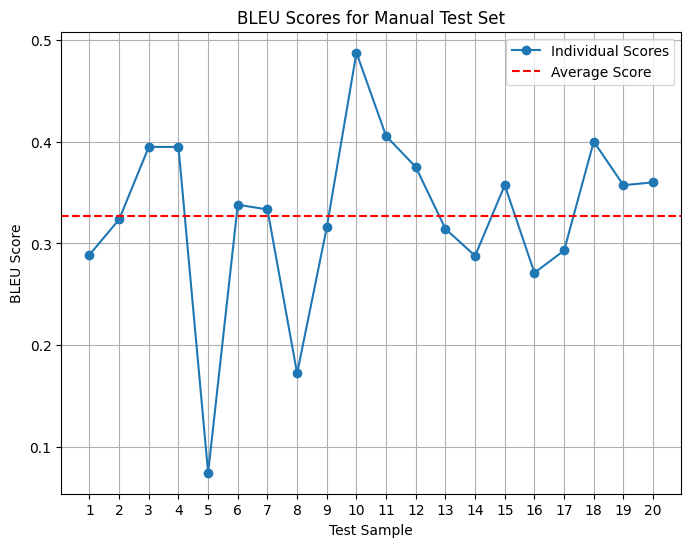

In [26]:
import matplotlib.pyplot as plt

avg_bleu = sum(scores) / len(scores)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), scores, marker='o', linestyle='-', label='Individual Scores')
plt.axhline(y=avg_bleu, color='r', linestyle='--', label='Average Score')
plt.title('BLEU Scores for Manual Test Set')
plt.xlabel('Test Sample')
plt.ylabel('BLEU Score')
plt.xticks(range(1, 21))
plt.grid(True)
plt.legend()
plt.show()